In [1]:
%pylab inline
!conda env export

Populating the interactive namespace from numpy and matplotlib
name: srp
dependencies:
- affine=1.2.0=py27_0
- backports_abc=0.4=py27_0
- bzip2=1.0.6=vc9_2
- cffi=1.5.2=py27_0
- click=6.3=py27_0
- cligj=0.2.0=py27_0
- cryptography=1.0.2=py27_0
- curl=7.45.0=vc9_1
- cycler=0.10.0=py27_0
- decorator=4.0.9=py27_0
- docopt=0.6.2=py27_0
- enum34=1.1.2=py27_0
- fiona=1.6.0=np110py27_0
- freetype=2.5.5=vc9_0
- gdal=2.0.0=py27_1
- geos=3.4.2=vc9_0
- hdf4=4.2.11=0
- hdf5=1.8.15.1=vc9_4
- idna=2.0=py27_0
- ipaddress=1.0.14=py27_0
- ipykernel=4.3.1=py27_0
- ipython=4.1.2=py27_0
- ipython-notebook=4.0.4=py27_3
- ipython_genutils=0.1.0=py27_0
- ipywidgets=4.1.1=py27_0
- jinja2=2.8=py27_0
- jpeg=8d=vc9_0
- jsonschema=2.4.0=py27_0
- jupyter=1.0.0=py27_1
- jupyter_client=4.2.1=py27_0
- jupyter_console=4.1.1=py27_0
- jupyter_core=4.1.0=py27_0
- kealib=1.4.5=vc9_0
- libgdal=2.0.0=vc9_2
- libnetcdf=4.3.3.1=vc9_5
- libpng=1.6.17=vc9_1
- libspatialindex=1.8.5=1
- libtiff=4.0.6=vc9_1
- markupsafe=0.23=py27_

In [2]:
import pandas as pd
from pandas import DataFrame
from os import path

In [3]:
data_dir = raw_input("Data directory: ")

Data directory: D:/srp


In [4]:
rawdata = pd.read_csv(path.join(data_dir, 'rungraph.txt'), sep='\t')

In [5]:
rawdata[:5]

,ObjId,PtId,x,y,z
0,58,0,-111.925523,33.480422,382.3
1,58,1,-111.925556,33.480422,382.3
2,58,2,-111.925588,33.480422,382.3
3,58,3,-111.925620,33.480423,382.3
4,58,4,-111.925654,33.480423,382.3


In [6]:
import cartopy
import cartopy.io.img_tiles
import cartopy.crs

In [7]:
figsize(15, 15)
tiler = cartopy.io.img_tiles.GoogleTiles()
epsg2223 = cartopy.crs.epsg(2223) # State Plane AZ Central (ft)
ax = plt.axes(projection=tiler.crs)
ax.add_image(tiler, 17)
ax.scatter(rawdata['x'], 
           rawdata['y'],
           s=0.1,
           zorder=5,
           transform=epsg2223.as_geodetic())

show()


AttributeError: get_content_extents

In [7]:
xmin, xmax = rawdata['x'].min(), rawdata['x'].max()
ymin, ymax = rawdata['y'].min(), rawdata['y'].max()
print xmin, xmax, ymin, ymax

-111.943614549 -111.925522849 33.4655532957 33.480701779


In [8]:
xyz = epsg2223.transform_points(epsg2223.as_geodetic(), 
                                np.asarray(rawdata['x']), 
                                np.asarray(rawdata['y']),
                                np.asarray(rawdata['z']),
                               )

In [9]:
xmin, ymin, zmin = xyz.min(0)
xmax, ymax, zmax = xyz.max(0)
print 'x(ft):', xmin, '--', xmax
print 'y(ft):', ymin, '--', ymax
print 'width(ft):', xmax-xmin
print 'height(ft):', ymax-ymin

x(ft): 691782.186442 -- 697299.731378
y(ft): 896917.559782 -- 902428.749975
width(ft): 5517.54493594
height(ft): 5511.19019279


the units of epsg2223 should be feet.  The study area appears to be about one square mile.

The resolution of the data seemt to be much higher than feet. We shold probably rasterize into 6inch bins (or less)

In [10]:
import rasterio
import liblas
import pyepsg
proj4_2223 = pyepsg.get(2223).as_proj4()

In [15]:
import os
meters_to_inches = 39.3701
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

# Now we will render out the LiDAR data
Do not execute the next cells if you already have rgbz0_inches.tif

In [19]:
folder = r'G:\SRP Scan data\AZ_SRP_Section34_Seiler\Export\Section34_LAS12_AZC_m'
files = [f for f in os.listdir(folder) if f.endswith('.las')]

print len(files), "LiDAR files"
print int(round(5.5*60*60/len(files))), "seconds per file on avg"

515 LiDAR files
38 seconds per file on avg


I have converted the next cell in this notebook to "raw" format, so that I do not accidentally execute it if I try to run every cell in the notebook. The next cell takes about 5 hours and 30 minutes to complete since it goes through all 515 LiDAR files. That is not so bad since it was around 38 seconds per lidar file. 

In [291]:
# The size of the image -- I think we can fit the whole study area into one big tile
ft_per_pixel = 1.0/12.0  
width=5000
height=5000

In [292]:
xmax = xmin + width*ft_per_pixel
ymax = ymin + height*ft_per_pixel

In [298]:
import time
import laspy

affine = rasterio.transform.from_bounds(xmin, ymin, xmax, ymax, width, height)
ras = np.ones((height, width, 4), dtype=float)*0xFFFFFFFF

poverall = FloatProgress(min=0, max=len(files))
p = FloatProgress(min=0, max=1)

display(poverall)
display(p)

epsg2223 = cartopy.crs.epsg(2223) # State Plane AZ Central (ft)
epsg26949 = cartopy.crs.epsg(26949) # State Plane AZ Central (m)


tstart = time.clock()

for file_index, basefn in enumerate(files):
    
    # Progress display so I know how long I have to get coffee
    poverall.value = file_index
    p.value = 0
    
    seconds = ((time.clock()-tstart)/max(file_index,1))*(len(files)-file_index)
    minutes, seconds = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    print "ETA:  %d:%02d:%02d" % (hours,  minutes, seconds)
    
    print basefn
    fn = os.path.join(folder, basefn)
    f = laspy.file.File(fn)
    
    fxmin, fymin = epsg2223.transform_point(f.header.min[0], f.header.min[1], epsg26949)
    fxmax, fymax = epsg2223.transform_point(f.header.max[0], f.header.max[1], epsg26949)
    
    if fxmax < xmin: continue
    if fxmin > xmax: continue
    if fymax < ymin: continue
    if fymin > ymax: continue
        
    x = f.x
    y = f.y
    z = f.z
    r = f.red
    g = f.green
    b = f.blue
    xyzf = epsg2223.transform_points(epsg26949, x, y, z)
    xyzf[:, 2] *= 12 #inches
    rc = np.column_stack(~affine*xyzf[:,:2].T).astype(int)

    print "\rSorting",
    indices = np.argsort(xyzf[:, 2] )
    valid_indices = ((rc[indices, 1] < width) 
                     & (rc[indices, 1] > 0) 
                     & (rc[indices, 0] < height)
                     & (rc[indices, 0] > 0))
    indices = indices[valid_indices]
    indices = indices[::-1]

    tmp = np.ones_like(ras)*0xFFFFFFFF
    chunksize  = 1000
    n = len(indices)
    print '\r', n,
    p.max = n
    for start in range(0, n, chunksize):
        end = min(start + chunksize, n)
        ix = indices[start:end]
        tmp[rc[ix, 0], rc[ix, 1], 0] = r[ix]
        tmp[rc[ix, 0], rc[ix, 1], 1] = g[ix]
        tmp[rc[ix, 0], rc[ix, 1], 2] = b[ix]
        tmp[rc[ix, 0], rc[ix, 1], 3] = xyzf[ix, 2]
        p.value = start
        print '\r{:>10} / {}'.format(end, n), 
    
    updates = tmp[:,:,3] < ras[:,:,3]
    ras[updates] = tmp[updates]
    

 ETA:  0:00:01
Lt._20130817(0)_LAS1_2.las
ETA:  0:00:03
Lt._20130817(1)_LAS1_2.las
   1066409 / 1066409 ETA:  0:53:57
Lt._20130817(10)_LAS1_2.las
ETA:  0:35:54
Lt._20130817(100)_LAS1_2.las
ETA:  0:26:53
Lt._20130817(101)_LAS1_2.las
ETA:  0:21:28
Lt._20130817(102)_LAS1_2.las
ETA:  0:17:51
Lt._20130817(103)_LAS1_2.las
ETA:  0:15:17
Lt._20130817(104)_LAS1_2.las
ETA:  0:13:21
Lt._20130817(105)_LAS1_2.las
ETA:  0:11:50
Lt._20130817(106)_LAS1_2.las
ETA:  0:10:38
Lt._20130817(107)_LAS1_2.las
ETA:  0:09:39
Lt._20130817(108)_LAS1_2.las
ETA:  0:08:50
Lt._20130817(109)_LAS1_2.las
ETA:  0:08:08
Lt._20130817(11)_LAS1_2.las
ETA:  0:07:33
Lt._20130817(110)_LAS1_2.las
ETA:  0:07:02
Lt._20130817(111)_LAS1_2.las
ETA:  0:06:35
Lt._20130817(112)_LAS1_2.las
ETA:  0:06:11
Lt._20130817(113)_LAS1_2.las
ETA:  0:05:49
Lt._20130817(114)_LAS1_2.las
ETA:  0:05:30
Lt._20130817(115)_LAS1_2.las
ETA:  0:05:13
Lt._20130817(116)_LAS1_2.las
ETA:  0:04:58
Lt._20130817(117)_LAS1_2.las
ETA:  0:04:44
Lt._20130817(118)_LAS1_2

In [382]:
from skimage.filter import gaussian_filter
sr = ras[:,:,:3].astype(float)/0xFFFF
mask = ras[:,:,3] == 0xFFFFFFFF 
sr[mask] = 0.5

In [383]:
sigma=0.5
    
for i in range(50):
    sr[mask,:] = gaussian_filter(sr, sigma)[mask,:]

figure()
imshow(sr)
figure()
imshow(ras[:,:,:3].astype(float)/0xFFFF)

KeyboardInterrupt: 

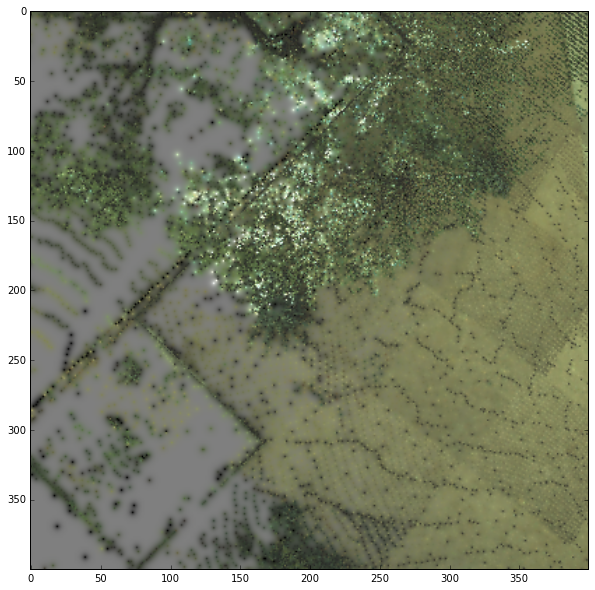

In [387]:
x, y = 3000, 3000
imshow(sr[x-200:x+200, y-200:y+200])

In [400]:
from skimage.morphology import square

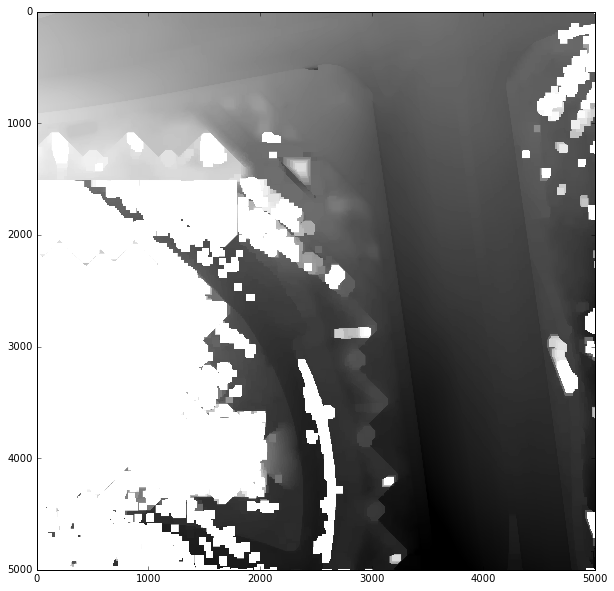

In [401]:
G = opening(ras[:,:,3], square(5*12))
imshow(G, vmin=vmin, vmax=vmax)

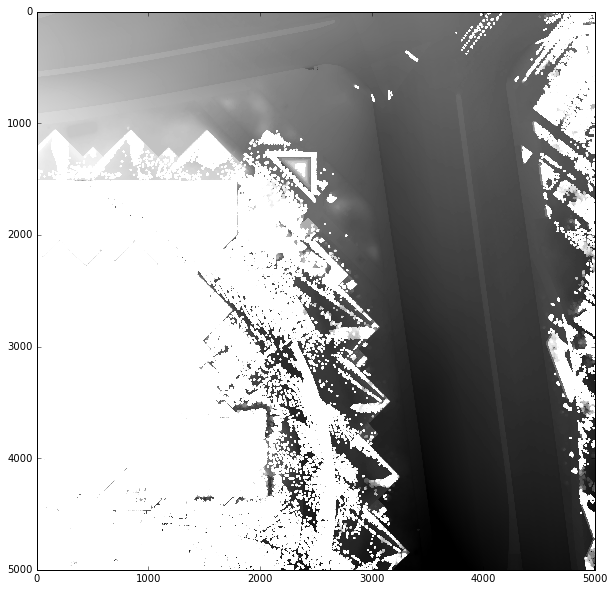

In [398]:
vmin, vmax=np.percentile(G[~mask], (1, 99))
imshow(G, vmin=vmin, vmax=vmax)

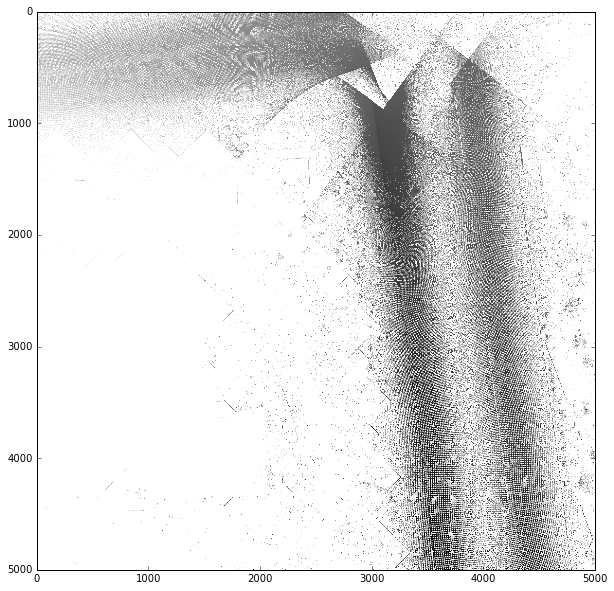

In [399]:
imshow(ras[:,:,3], vmin=vmin, vmax=vmax)

In order to avoid using too many parameters, I keep the raster image parameters in a dictionary called profile

If the raster was already generated, we can just load it from disk. 

In [22]:
with rasterio.open('rgbz0_inches3.tif', mode='r') as ds:
    affine = ds.affine
    ras = ds.read().transpose(2,1,0)
print ras.shape

(11036L, 11023L, 4L)


15415.6315632 15459.0347466


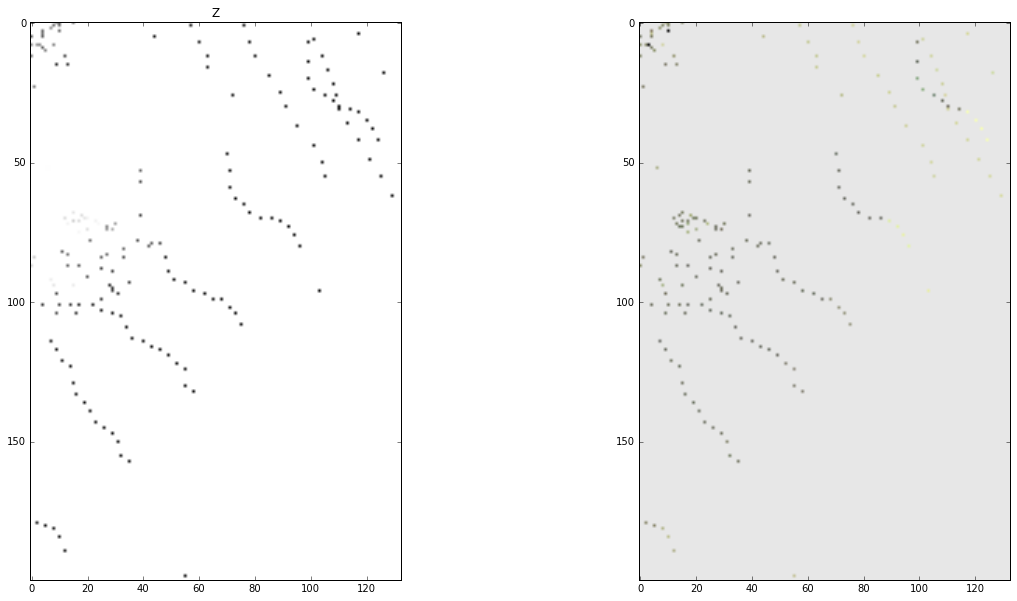

In [299]:
sample_site = (693127.4977482168, 899945.426647059) # (692156.90,902044.55)
row, col = ~ds.affine*sample_site
row, col = int(round(row)), int(round(col))
figsize(20,10)
gray()
sub = ras[row-100:row+100, col-100:col+100].copy()
alpha = sub[:,:,3] < 0xFFFFFFFF
vmin, vmax = np.percentile(sub[:,:,3][alpha], (10, 98))
print vmin,  vmax

subplot(1,2,1)
imshow(sub[:,:,3], vmin=vmin, vmax=vmax)
title('Z')

subplot(1,2,2)
vmin, vmax = np.percentile(sub[:,:,:3][alpha], (0, 100))
imshow((sub[:,:,:3]-vmin)/(vmax-vmin));


In [28]:
average_cabinet_width = 1.0 #meters
cabinet_width_in_inches = average_cabinet_width * meters_to_inches
cabinet_width_in_pixels = cabinet_width_in_inches / 6  #6 inches per pixel
max_cabinet_width = int(1.5 * cabinet_width_in_pixels)
print 'average_cabinet_width', average_cabinet_width
print 'cabinet_width_in_inches', cabinet_width_in_inches
print 'cabinet_width_in_pixels', cabinet_width_in_pixels
print 'max_cabinet_width', max_cabinet_width

average_cabinet_width 1.0
cabinet_width_in_inches 39.3701
cabinet_width_in_pixels 6.56168333333
max_cabinet_width 9


In [29]:
from skimage.morphology import opening, disk
structuring_element = disk(max_cabinet_width//2 + 1)
Z = ras[:,:, 3]
Zground = opening(Z, selem=structuring_element)

In [30]:
from skimage.filter import sobel_h

In [76]:
epsg2223.transform_point( -111.939205, 33.473875, epsg2223.as_geodetic())

(693127.4977482168, 899945.426647059)

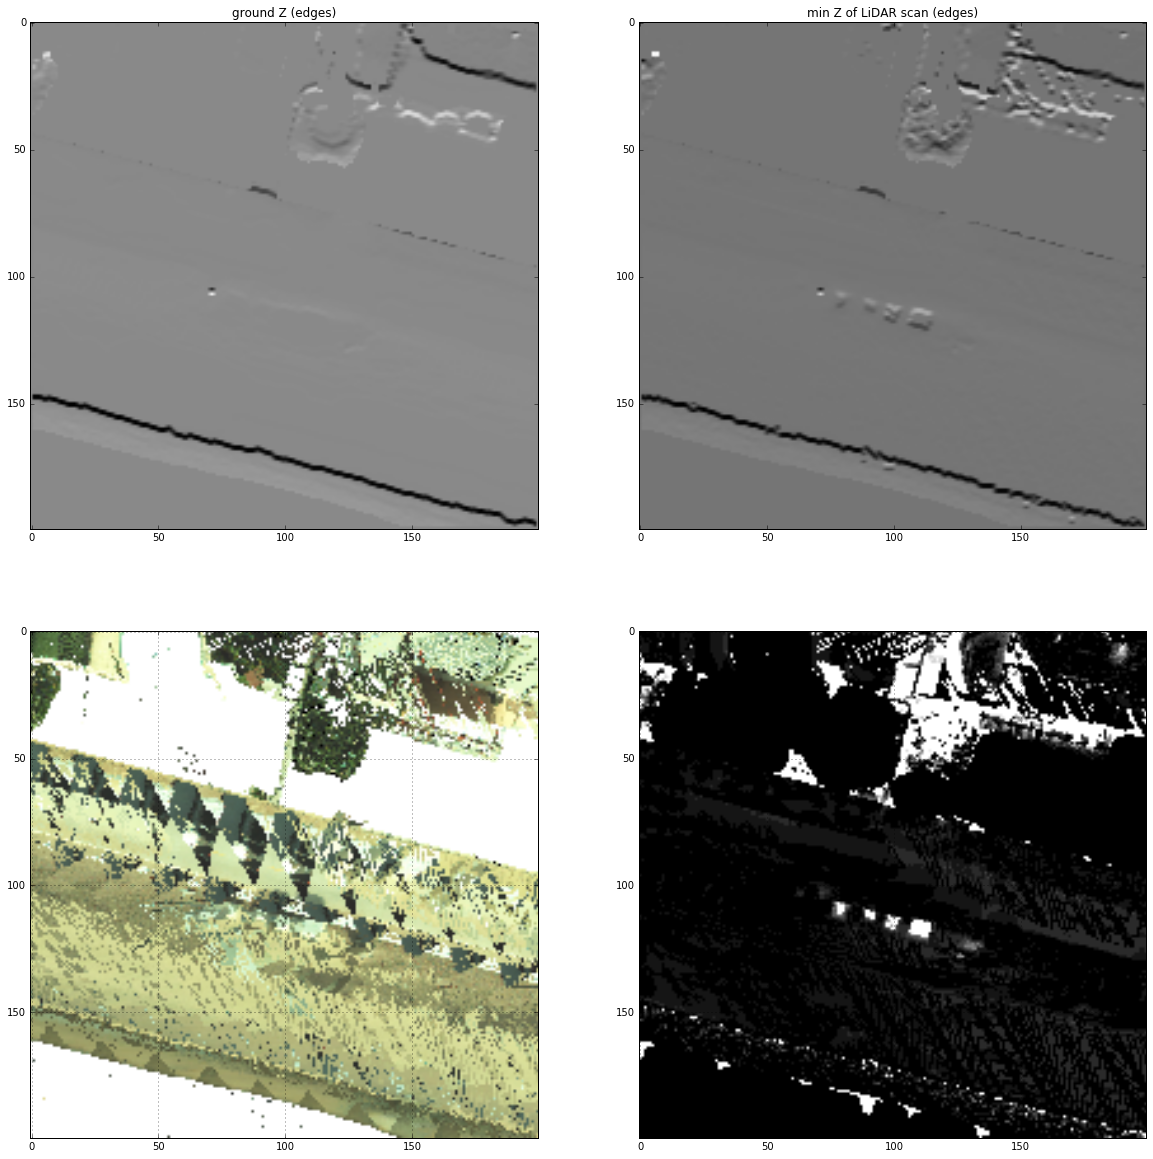

In [259]:
def visualize(lat, lon, radius=50):
    row, col = ~ds.affine*(lat, lon)
    row, col = int(round(row)), int(round(col))
    figsize(20,20)
    gray()
    subZground = Zground[row-radius:row+radius, col-radius:col+radius].copy()
    subZ = Z[row-radius:row+radius, col-radius:col+radius].copy()
    alpha = subZ[:,:] < 0xFFFFFFFF
    subRGB = ras[row-radius:row+radius, col-radius:col+radius,:3].copy().astype(float)
    subRGB /= subRGB[alpha].max()

    subplot(2,2,1)
    imshow(sobel_h(subZground, alpha))
    title('ground Z (edges)')

    subplot(2,2,2)
    imshow(sobel_h(subZ, alpha))
    title('min Z of LiDAR scan (edges)')
    
    subplot(2,2,3)
    imshow(subRGB)
    grid()
    
    subplot(2,2,4)
    dz = (subZ-subZground).astype(float)

    imshow(dz/12.0, vmin=0, vmax=1)
    grid()
    #colorbar()


#visualize(692156.90,902044.55-500, radius=200)
visualize(693127.4977482168, 899945.426647059, radius=100)

In [79]:
diff = Z - Zground
diff[Z == 0xFFFFFFFF] = 0

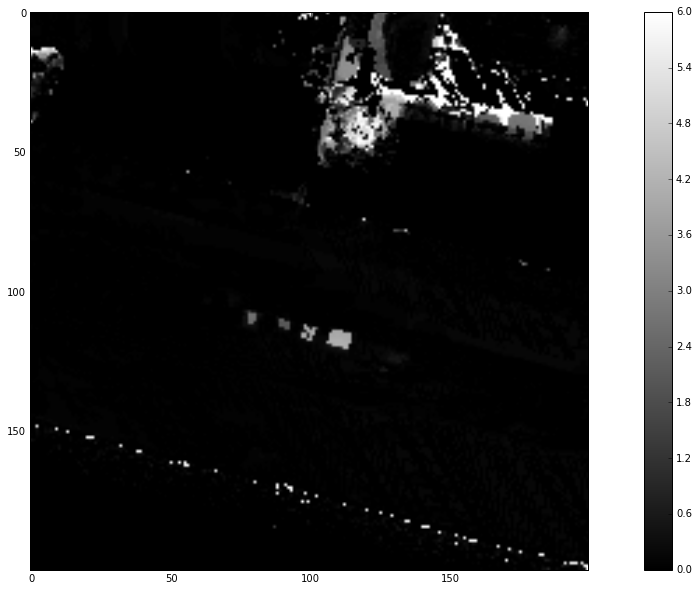

In [249]:
subDiff = diff[row-100:row+100, col-100:col+100]
imshow(subDiff/12., vmax=6)  # Up to six feet in height
colorbar();

In [120]:
from skimage.measure import label
from skimage.segmentation import mark_boundaries
from skimage.morphology import opening, disk, closing

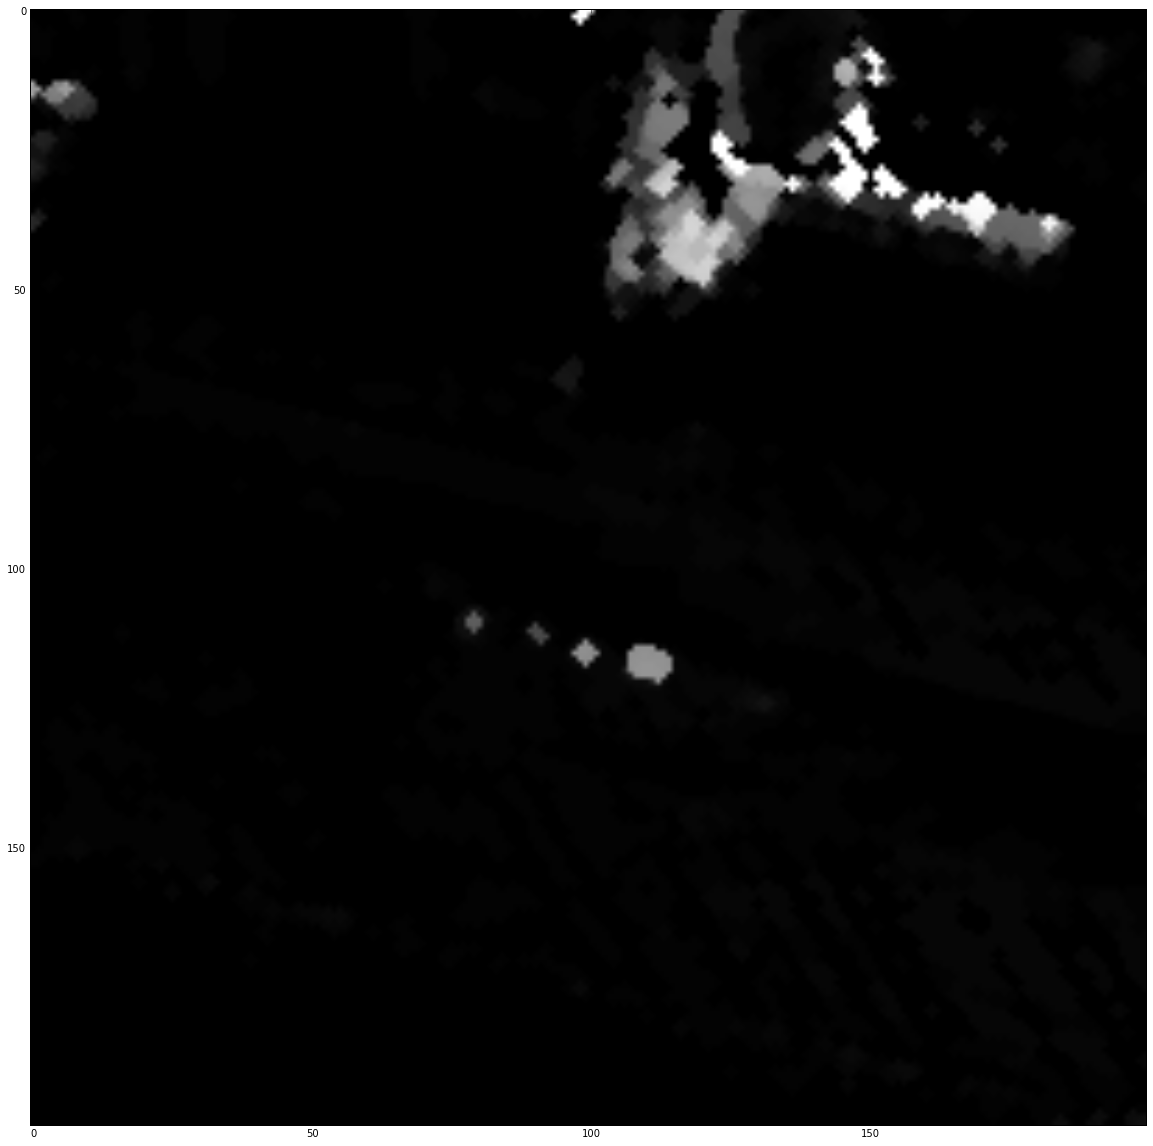

In [262]:
tmp = opening(closing(subDiff, disk(1)), disk(1))
#imshow(mark_boundaries(tmp/(10*12.0), label(tmp > 12) ))
imshow(tmp/12.0, vmax=7)

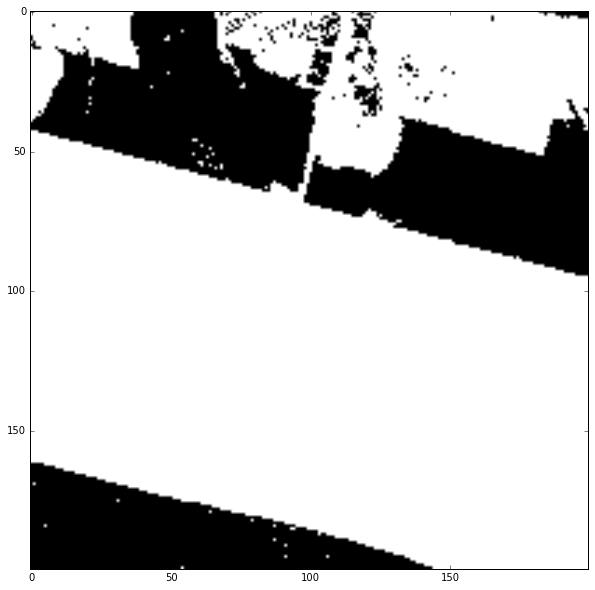

In [255]:
imshow(alpha)

In [263]:
from skimage.measure import regionprops
import pandas as pd
labels = label(tmp>24)
regions = regionprops(labels, subDiff)  

In [264]:
data = numpy.zeros((len(regions), 4))
for i, r in enumerate(regions):
    data[i] = r.min_intensity, r.max_intensity, r.area, r.perimeter

In [265]:
df = pd.DataFrame(data, columns=['min z', 'max z', 'area', 'perimeter'])
df

,min z,max z,area,perimeter
0,0,94,7,7.656854
1,22,31,54,33.798990
2,0,116,47,22.763456
3,0,4,5,5.656854
4,0,93,449,174.350288
5,40,153,20,15.899495
6,0,97,33,20.970563
7,0,95,72,36.455844
8,1,83,13,10.485281
9,0,93,21,14.727922


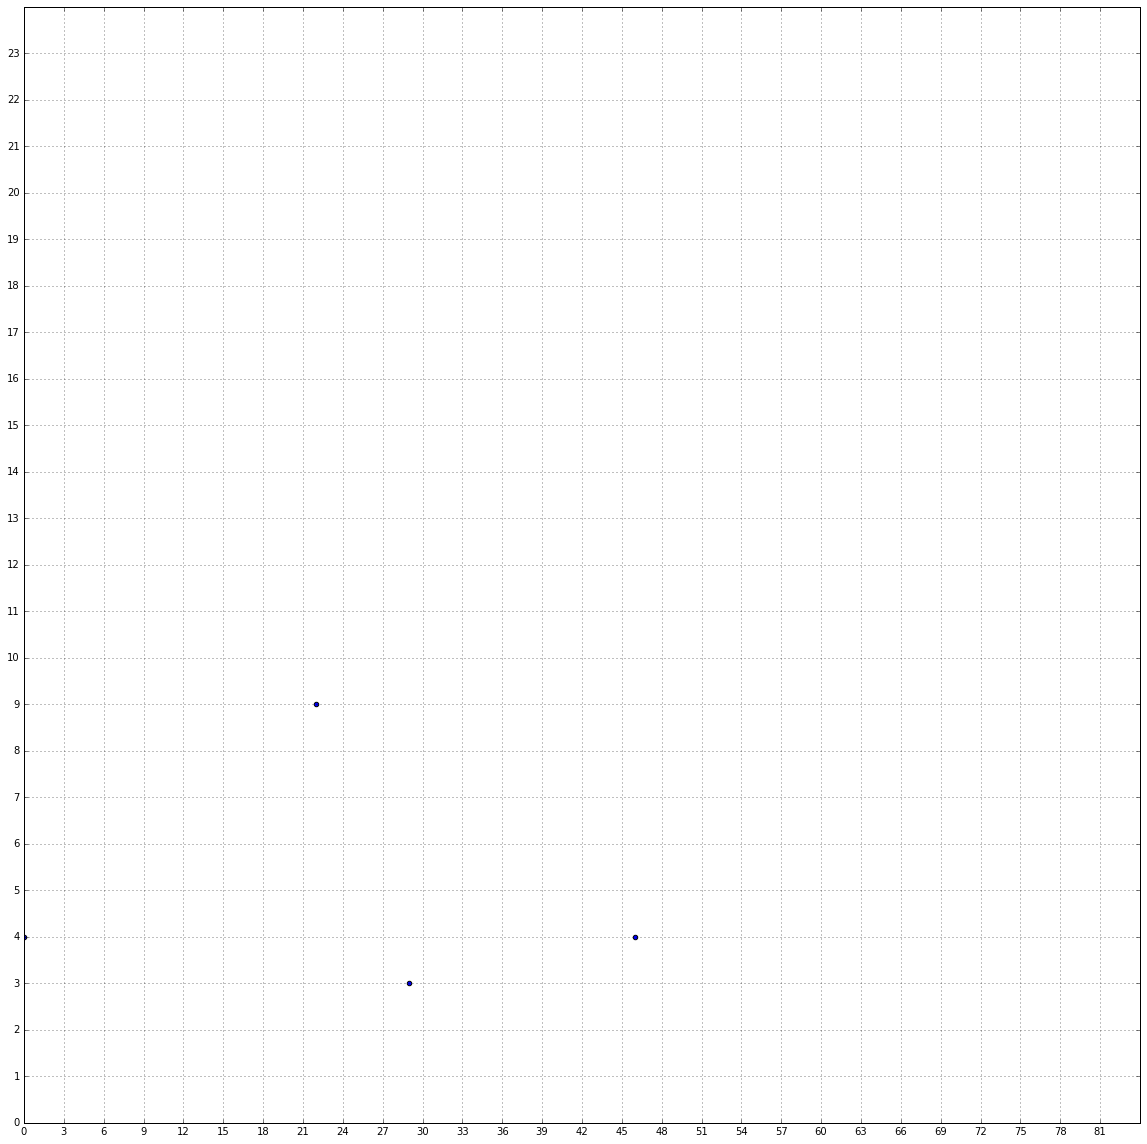

In [266]:
scatter(df['min z'], df['max z']-df['min z'])
grid()
xlim(0, 7*12)
ylim(0, 2*12)
yticks(arange(0, 2*12));xticks(arange(0, 7*12, 3));

,min z,max z,area,perimeter
0,0,94,7,7.656854
1,22,31,54,33.798990
2,0,116,47,22.763456
3,0,4,5,5.656854
4,0,93,449,174.350288
5,40,153,20,15.899495
6,0,97,33,20.970563
7,0,95,72,36.455844
8,1,83,13,10.485281
9,0,93,21,14.727922


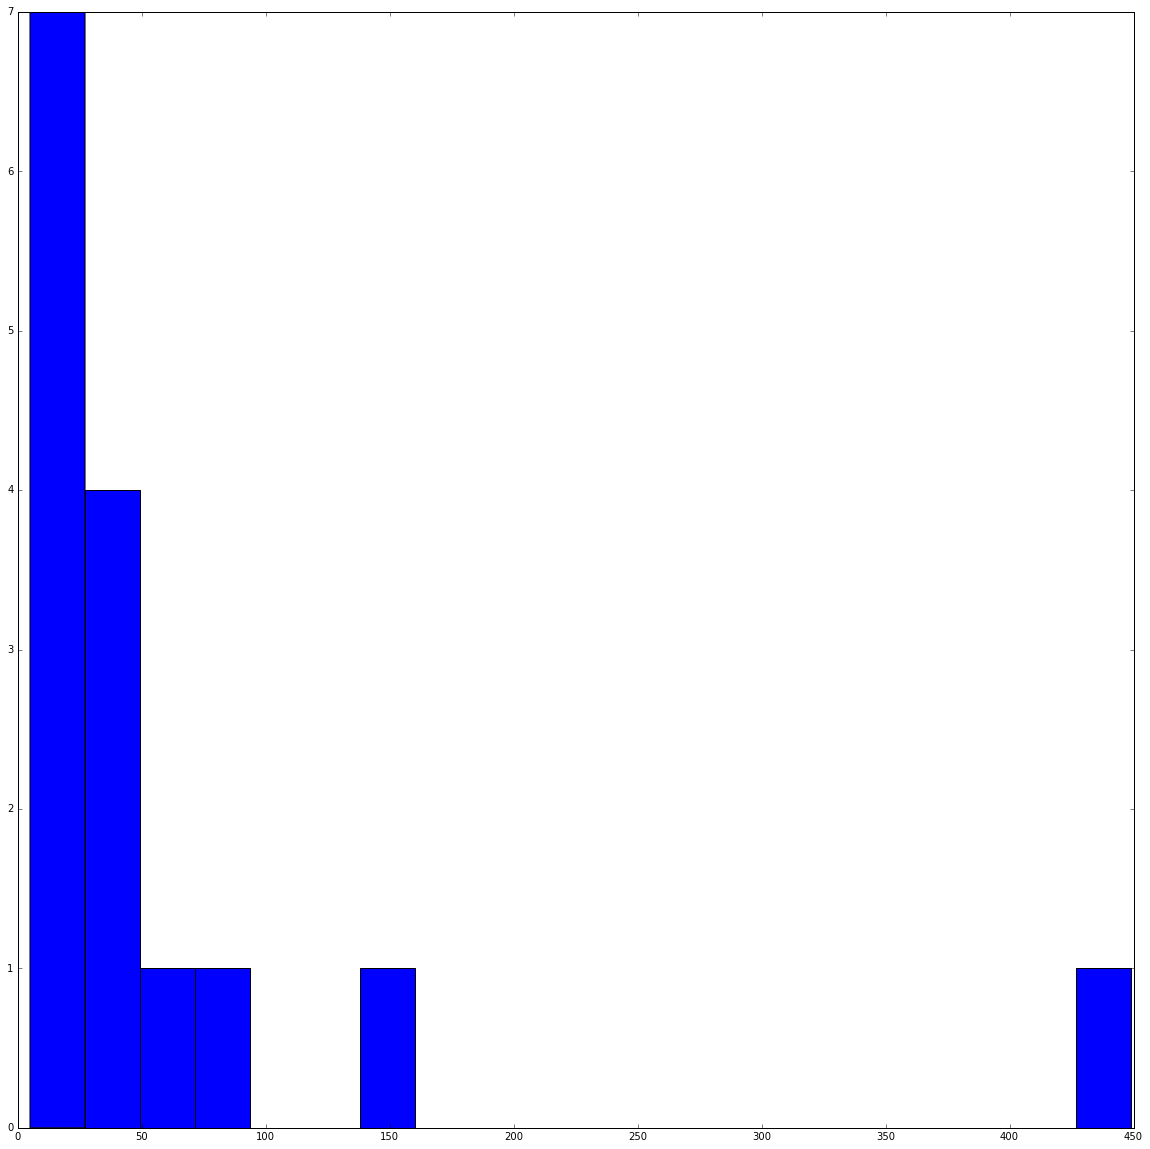

In [267]:
hist(df['area'], bins=20);
display(df)

In [268]:
df["max z"]/12

0      7.833333
1      2.583333
2      9.666667
3      0.333333
4      7.750000
5     12.750000
6      8.083333
7      7.916667
8      6.916667
9      7.750000
10     7.750000
11     6.250000
12     2.666667
13     4.000000
14     4.166667
Name: max z, dtype: float64

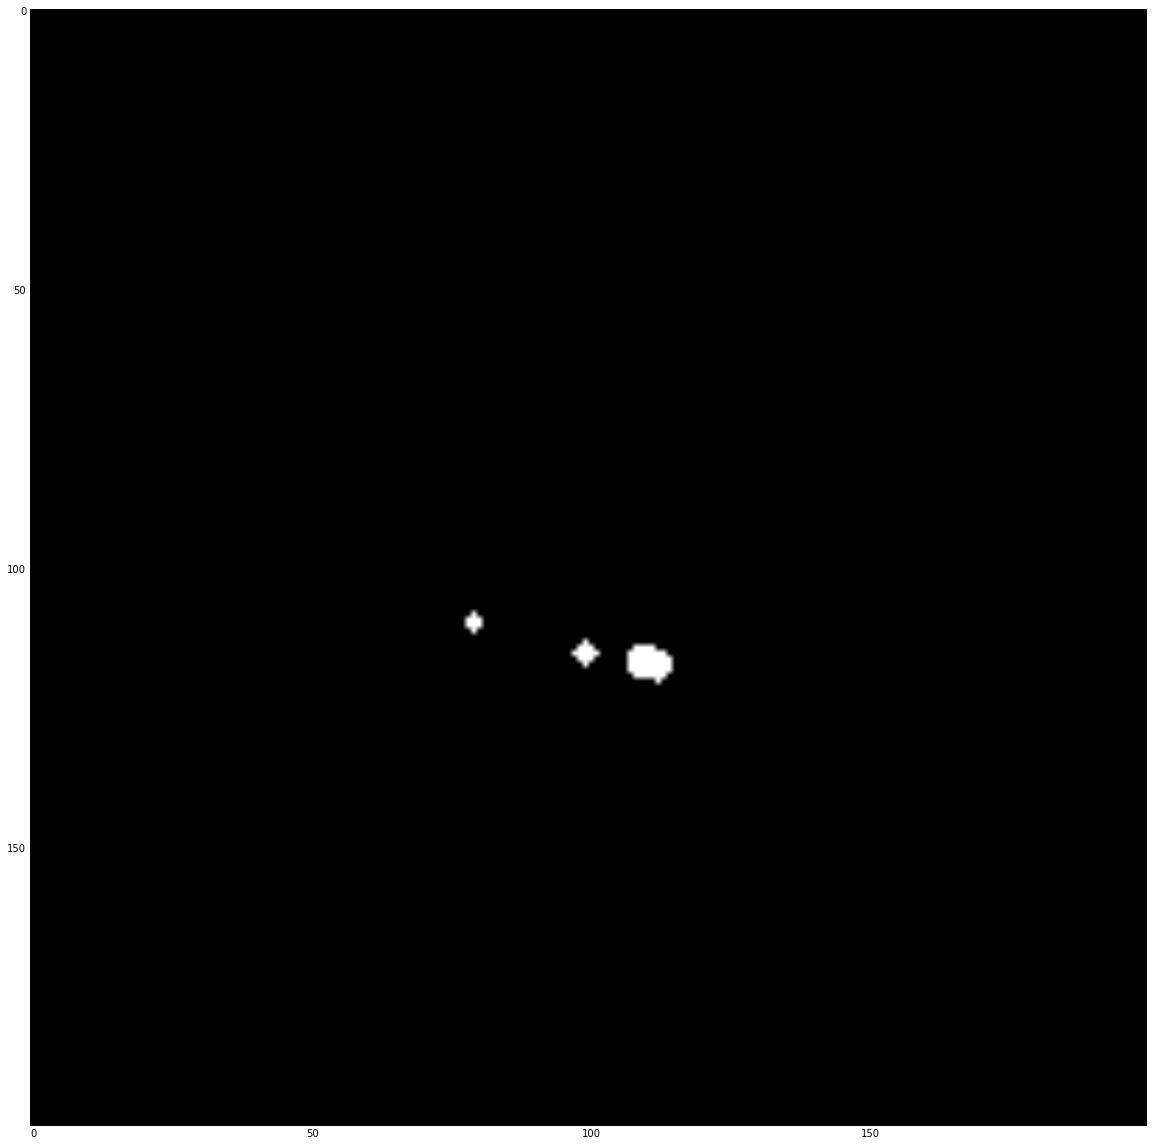

In [272]:
imshow(sum([(labels == x) for x in (13+1, 14+1, 12+1,)], axis=0));

uint32


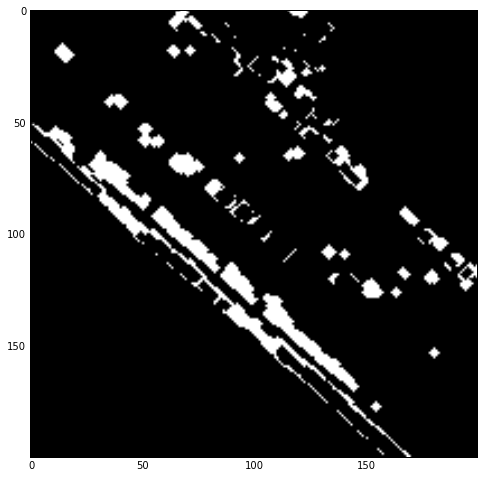

In [168]:
figsize(8,8)
imshow(tmp == 1);
print tmp.dtype

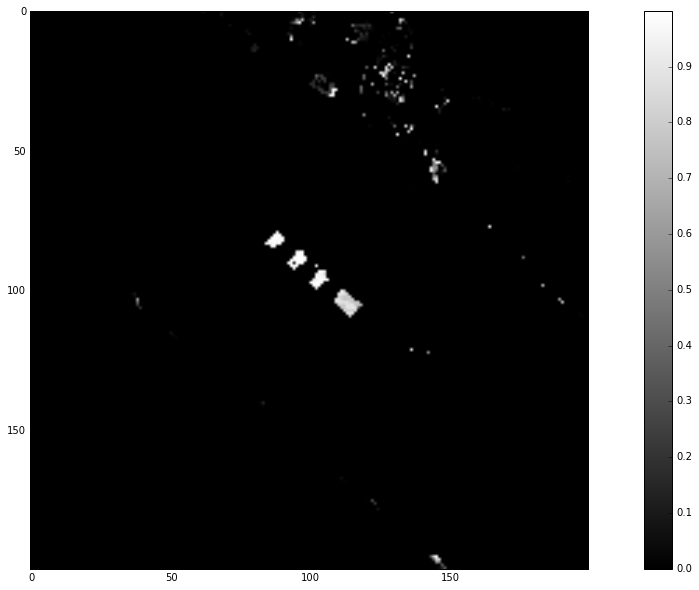

In [487]:
mean_height = 4*12  #Ball park guess
stdev_height = 12 # +/1 one foot?
imshow(exp( -(subDiff-mean_height)**2/(stdev_height**2)  ))
colorbar()

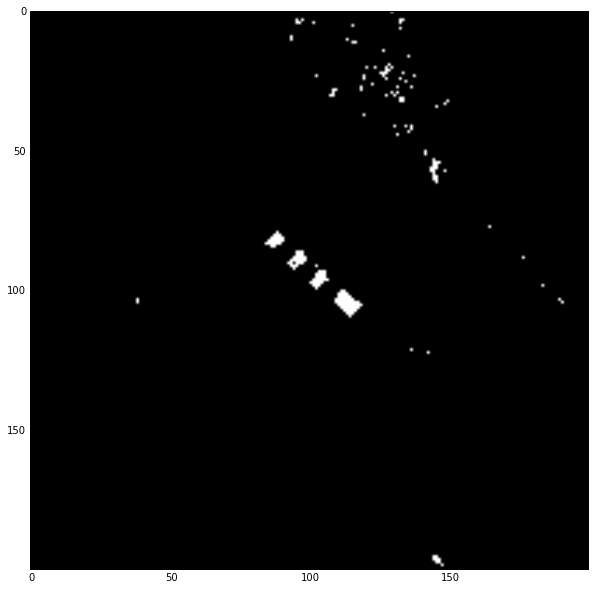

In [490]:
imshow(abs(subDiff-mean_height) <= stdev_height)  # 68% rule --> majority of box points within this range

In [491]:
from skimage.morphology import binary_opening, binary_closing

In [587]:
def binary_seive(a, minsize, maxsize):
    return binary_opening(a, disk(minsize)) &~ binary_opening(a, disk(maxsize))

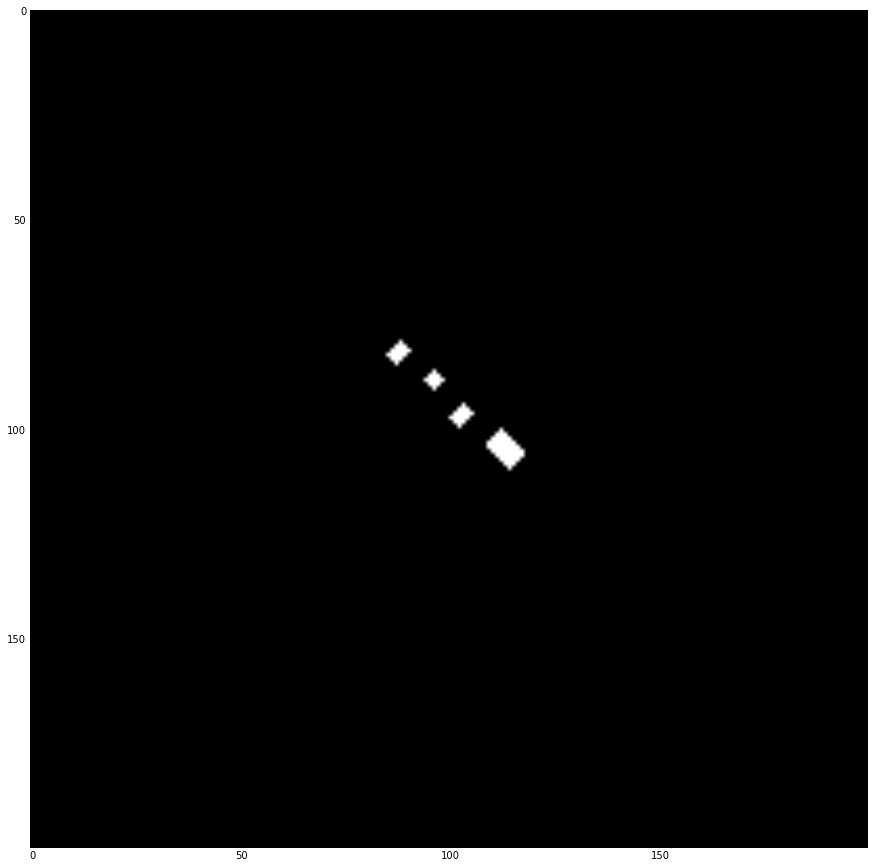

In [588]:
sub_box_tops = abs(subDiff-mean_height) <= stdev_height   
# 68% probability threshold  -- according to my made up mean +stdev....
sub_box_tops = binary_seive(sub_box_tops, cabinet_width_in_pixels//4 + 1,  cabinet_width_in_pixels)
imshow(sub_box_tops);

In [563]:
prbs = exp(-(diff - mean_height)**2/(stdev_height**2))

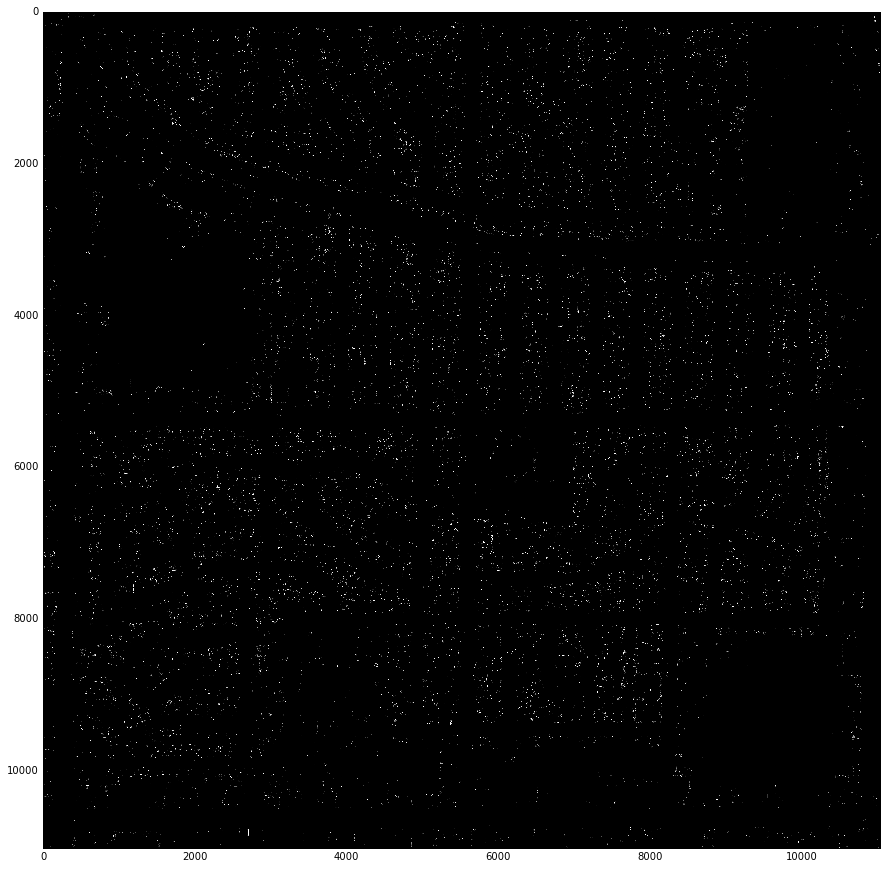

In [589]:
box_tops = abs(diff - mean_height) < stdev_height
imshow(box_tops)

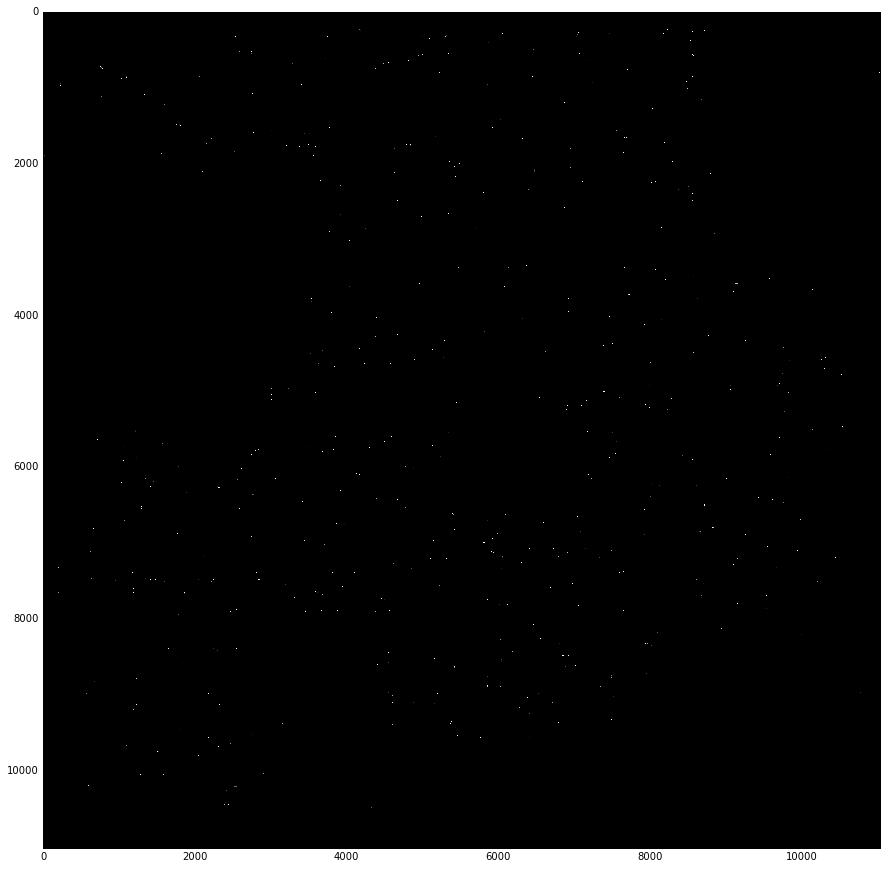

In [591]:
box_tops = binary_seive(box_tops, cabinet_width_in_pixels//4 + 1,  cabinet_width_in_pixels)
imshow(box_tops);

In [502]:
from skimage.measure import regionprops, label

In [592]:
labeled_box_tops = label(box_tops)

In [599]:
props = regionprops(labeled_box_tops, diff)

In [612]:
len(props)
index = randint(0, len(props))
region = props[index]

In [613]:
region.centroid

(4534.0, 3519.0)

In [614]:
from skimage.segmentation import mark_boundaries

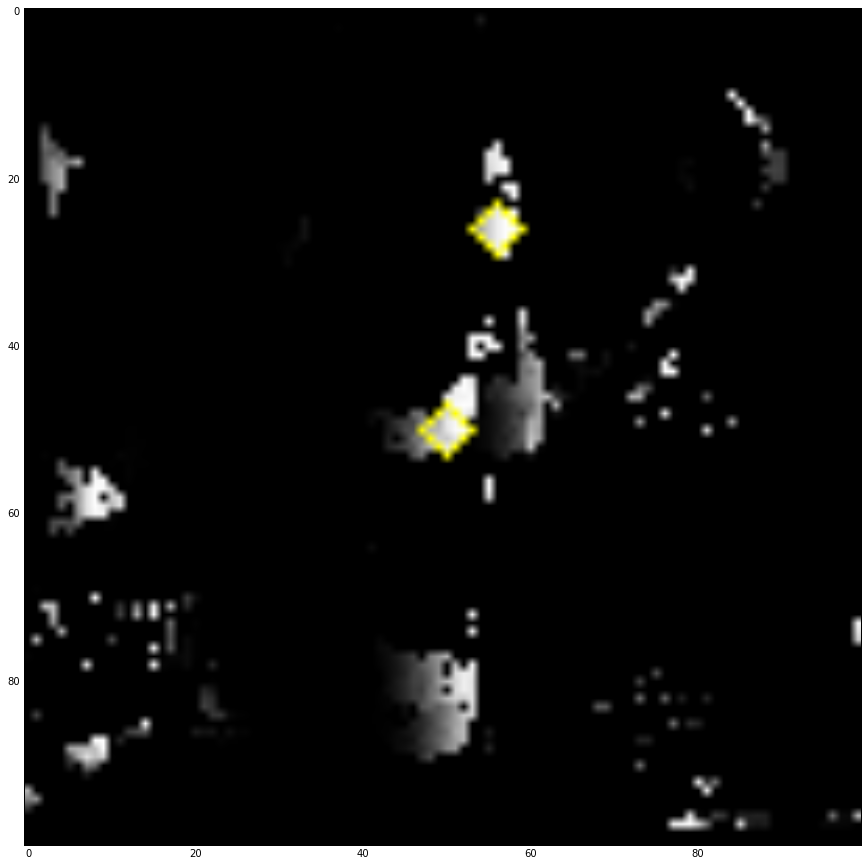

In [615]:
row, col = region.centroid
rad = 50
row, col = int(row), int(col)
#imshow(ras[row-rad:row+rad, col-rad:col+rad, :3]/0xFFFF)
# imshow(mark_boundaries( (255*ras[row-rad:row+rad, col-rad:col+rad, :3]/0xFFFF).astype(np.uint8), 
#                        box_tops[row-rad:row+rad, col-rad:col+rad].astype(int)))

# imshow(mark_boundaries( diff[row-rad:row+rad, col-rad:col+rad]/diff[row-rad:row+rad, col-rad:col+rad].max(), 
#                        box_tops[row-rad:row+rad, col-rad:col+rad].astype(int)))

imshow(mark_boundaries( prbs[row-rad:row+rad, col-rad:col+rad]/prbs[row-rad:row+rad, col-rad:col+rad].max(), 
                       box_tops[row-rad:row+rad, col-rad:col+rad].astype(int)))

In [604]:
gx, gy = ds.affine*(row, col)
print gx, gy
lat, lon = epsg2223.as_geodetic().transform_point(gx, gy, epsg2223)
print  round(lon, 6), ',', round(lat, 6)

693945.008061 900532.356579
33.475489 , -111.936524


In [616]:
import fiona

In [618]:
schema = {}
schema['geometry'] = 'Point'
schema['properties'] = [('height', 'float')]
crs=pyepsg.get(2223).as_proj4()

In [621]:
recs =[]
for r in props:
    x, y = ds.affine*r.centroid
    rec = {}
    rec['geometry'] = {'type':'Point', 'coordinates':(x, y)}
    rec['properties'] = {'height': r.max_intensity}
    recs.append(rec)

In [633]:
ep = pyepsg.get(2223).base_geodetic_crs.as_proj4()

u'+proj=longlat +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +no_defs '

In [624]:
with fiona.open('boxes1', 'w', driver="ESRI Shapefile", crs=crs, schema=schema) as s:
    s.writerecords(recs)

In [637]:
trail = zip(list(rawdata['x']), list(rawdata['y']))
trail_record = {
    'geometry': {'type':'LineString', 'coordinates':trail},
    'properties': {}
}
trail_schema = {'geometry':'LineString', 'properties':[]}
trail_crs = pyepsg.get(2223).base_geodetic_crs.as_proj4()
with fiona.open('trail', 'w', driver="ESRI Shapefile", crs=trail_crs, schema=trail_schema) as s:
    s.writerecords([trail_record])

In [638]:
0xFFFFFFFF

4294967295L

In [641]:
profile = {}
profile.update(driver='GTiff', compress='lzw')
ft_per_pixel = 6.0/12.0  # 6 inches (0.5 ft)\
width=int(ceil((xmax-xmin)/ft_per_pixel))
height=int(ceil((ymax-ymin)/ft_per_pixel))
profile.update(width=width,  height=height)
profile.update(count=1)
profile.update(crs=proj4_2223)
profile.update(transform=rasterio.transform.from_bounds(xmin, ymin, xmax, ymax, width, height))
profile.update(dtype=rasterio.float32, nodata=0xFFFFFFFF)
with rasterio.open('probs.tif', mode='w', **profile) as ds:
    ds.write(prbs[:,:].T.astype(np.float32), 1)
    


In [642]:
profile = {}
profile.update(driver='GTiff', compress='lzw')
ft_per_pixel = 6.0/12.0  # 6 inches (0.5 ft)\
width=int(ceil((xmax-xmin)/ft_per_pixel))
height=int(ceil((ymax-ymin)/ft_per_pixel))
profile.update(width=width,  height=height)
profile.update(count=1)
profile.update(crs=proj4_2223)
profile.update(transform=rasterio.transform.from_bounds(xmin, ymin, xmax, ymax, width, height))
profile.update(dtype=rasterio.float32, nodata=0xFFFFFFFF)
with rasterio.open('ground.tif', mode='w', **profile) as ds:
    ds.write(Zground[:,:].T.astype(np.float32), 1)
    

In [649]:
import time
poverall = FloatProgress(min=0, max=len(files))
display(poverall)
p = FloatProgress(min=0, max=1)
display(p)
workdone = 0

print "Allocating..."
maxras = np.zeros((height, width, 4), dtype=np.uint32)
sources = np.zeros((height, width), dtype=np.uint16)
print "Allocated...."

tstart = time.clock()

for file_index, basefn in enumerate(files):
    
    # Progress display so I know how long I have to get coffee
    poverall.value = file_index
    p.value = 0
    
    seconds = ((time.clock()-tstart)/max(file_index,1))*(len(files)-file_index)
    minutes, seconds = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    print "ETA:  %d:%02d:%02d" % (hours,  minutes, seconds)
    
    print basefn
    fn = os.path.join(folder, basefn)
    f = laspy.file.File(fn)
    x = f.x
    y = f.y
    z = f.z
    r = f.red
    g = f.green
    b = f.blue
    xyzf = epsg2223.transform_points(epsg26949, x, y, z)
    xyzf[:, 2] *= 12 #inches
    rc = np.column_stack(~affine*xyzf[:,:2].T).astype(int)

    print "\rSorting",
    indices = np.argsort(xyzf[:, 2] )
    valid_indices = ((rc[indices, 1] < width) 
                     & (rc[indices, 1] > 0) 
                     & (rc[indices, 0] < height)
                     & (rc[indices, 0] > 0))
    indices = indices[valid_indices]

    tmp = np.zeros_like(maxras)
    chunksize  = 1000
    n = len(indices)
    print '\r', n,
    p.max = n
    for start in range(0, n, chunksize):
        end = min(start + chunksize, n)
        ix = indices[start:end]
        tmp[rc[ix, 0], rc[ix, 1], 0] = r[ix]
        tmp[rc[ix, 0], rc[ix, 1], 1] = g[ix]
        tmp[rc[ix, 0], rc[ix, 1], 2] = b[ix]
        tmp[rc[ix, 0], rc[ix, 1], 3] = xyzf[ix, 2]
        p.value = start
        print '\r{:>10} / {}'.format(end, n), 
    
    updates = tmp[:,:,3] > maxras[:,:,3]
    maxras[updates] = tmp[updates]
    sources[updates] = file_index
    
    xmin_, ymin_ = rc.min(0)
    xmax_, ymax_ = rc.max(0)
    clear_output()
    
    # Save images for debugging
    im = maxras[xmin_:xmax_, ymin_:ymax_, 3].copy()
    vmean = xyzf[:,2].mean()
    vdev = xyzf[:,2].std()
    vmin = vmean - vdev
    vmax = vmean + vdev
    try:
        if not os.path.isdir('tmp'):
            os.makedirs('tmp')
        imsave('tmp/'+ basefn +'.tif', im, cmap=cm.gray, vmin=vmin, vmax=vmax);
        imshow(im, cmap=cm.gray, vmin=vmin, vmax=vmax);
        show()
    except:
        print "Image was probably too small to save / show. This is an apparent bug in the imsave function."
    display()

 Image was probably too small to save / show. This is an apparent bug in the imsave function.
